In [1]:
import numpy as np
import pandas as pd
import math
import pickle

from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
DATAFRAME_PATH = 'data/labeled_comments.csv'
TF_QUANTITY = 100
GENERATE_TRAIN_TEST = False
MODELS_PATH = './data/models'

from utils import *

# Dataset details

In [3]:
df = pd.read_csv(DATAFRAME_PATH, sep=';')
df

,comment_id,content,likes,dislikes,votes,avg,std,label,char-qty,word-qty,legibility-index
0,1489,MUITO MAIS LEGAL RRSRSRRSRSRS,2.0,0.0,4,0.000000,0.000000,0,30,5,223.62
1,273,Canhão de guerra.,2.0,4.0,3,1.000000,0.000000,1,18,4,190.91
2,2574,femi o que?,10.0,11.0,3,1.000000,0.000000,1,11,3,217.59
3,951,Concordo plenamente Jaqueline!! Outro dia ouvi...,20.0,0.0,3,0.666667,0.577350,1,161,27,228.87
4,2520,Feminista é uma mulher encalhada que precisa d...,11.0,11.0,4,1.000000,0.000000,1,66,11,226.84
...,...,...,...,...,...,...,...,...,...,...,...
3583,55,Brigue esquisitinha,0.0,1.0,3,0.666667,0.577350,1,19,2,204.50
3584,3858,"Pois é, todo o bozopata é assim! Depois que pe...",3.0,0.0,4,0.250000,0.500000,0,192,35,228.41
3585,3984,Será que ninguém tem coragem de enfrentar algu...,0.0,0.0,4,0.000000,0.000000,0,368,60,230.27
3586,790,Perfeito!,2.0,2.0,5,0.400000,0.547723,0,9,1,163.22


In [4]:
df.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty,legibility-index
count,3588.000000,3340.000000,3340.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000
mean,1933.801282,15.548802,9.806287,3.359810,0.524891,0.276492,0.492196,138.460981,24.262542,223.059866
std,1142.972029,40.010881,41.683277,0.653204,0.376775,0.278900,0.529788,136.592065,23.625002,15.836094
min,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,1.000000,-5.300000
25%,992.750000,2.000000,0.000000,3.000000,0.250000,0.000000,0.000000,47.000000,9.000000,223.620000
50%,1894.500000,5.000000,1.000000,3.000000,0.600000,0.000000,1.000000,94.000000,17.000000,228.180000
75%,2796.250000,14.000000,6.000000,4.000000,1.000000,0.577350,1.000000,179.000000,32.000000,229.810000
max,4283.000000,729.000000,1196.000000,9.000000,1.000000,0.707107,1.000000,958.000000,176.000000,230.300000


<div class="alert alert-info">
    <b>Dataset fields description</b>
    <hline/>
    <p><b>comment_id</b>: unique identifier to each comment from database</p>
    <p><b>content</b>: comment text content</p>
    <p><b>likes</b>: comment likes quantity</p>
    <p><b>dislikes</b>: comment dislikes quantity</p>
    <p><b>votes</b>: number of users that labeled the comment</p>
    <p><b>avg</b>: average of each vote value to the comment</p>
    <p><b>std</b>: standard deviation of each vote value to the comment</p>
    <p><b>label</b>: final label assigned to the comment, label 1 represents sexist comments and label 0 represets not sexist comments</p>
    <p><b>char-qty</b>: number of characters in the comment </p>
    <p><b>word-qty</b>: number of words in the comment</p>
    <p><b>legibility-index</b>: fleschbr legibility index to the comment</p>
</div>

<div class="alert alert-info">
A visual data analysis is avaliable at https://datastudio.google.com/s/sgO8X7JORMU
</div>

In [5]:
sexist_df = df[df['avg'] > 0.5]
not_sexist_df = df[df['avg'] < 0.5]

In [6]:
sexist_df.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty,legibility-index
count,1821.000000,1708.000000,1708.000000,1821.000000,1821.000000,1821.000000,1821.0,1821.000000,1821.000000,1821.000000
mean,1837.840198,17.719555,13.120023,3.388248,0.858459,0.246307,1.0,139.797913,24.602965,223.953432
std,1046.365247,39.877321,50.503687,0.691593,0.160983,0.275718,0.0,137.304962,23.833603,13.723964
min,5.000000,0.000000,0.000000,2.000000,0.555556,0.000000,1.0,2.000000,1.000000,-5.300000
25%,997.000000,2.000000,0.000000,3.000000,0.666667,0.000000,1.0,51.000000,9.000000,223.620000
50%,1730.000000,7.000000,2.000000,3.000000,1.000000,0.000000,1.0,95.000000,17.000000,228.580000
75%,2562.000000,16.000000,8.000000,4.000000,1.000000,0.577350,1.0,177.000000,31.000000,229.900000
max,4283.000000,688.000000,1196.000000,9.000000,1.000000,0.577350,1.0,958.000000,176.000000,230.300000


In [7]:
not_sexist_df.describe()

,comment_id,likes,dislikes,votes,avg,std,label,char-qty,word-qty,legibility-index
count,1712.000000,1579.000000,1579.000000,1712.000000,1712.000000,1712.000000,1712.0,1712.000000,1712.000000,1712.000000
mean,2037.534463,13.557315,6.416086,3.311332,0.170885,0.298782,0.0,137.175234,23.926986,222.318808
std,1226.129408,40.662227,29.847156,0.606347,0.161891,0.278785,0.0,134.949975,23.240212,17.514909
min,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,2.000000,1.000000,0.000000
25%,991.750000,1.000000,0.000000,3.000000,0.000000,0.000000,0.0,44.000000,8.000000,223.387500
50%,2030.500000,4.000000,1.000000,3.000000,0.250000,0.500000,0.0,91.000000,16.000000,227.970000
75%,2989.250000,12.000000,4.000000,4.000000,0.333333,0.577350,0.0,183.000000,32.250000,229.710000
max,4282.000000,729.000000,842.000000,7.000000,0.428571,0.577350,0.0,950.000000,159.000000,230.300000


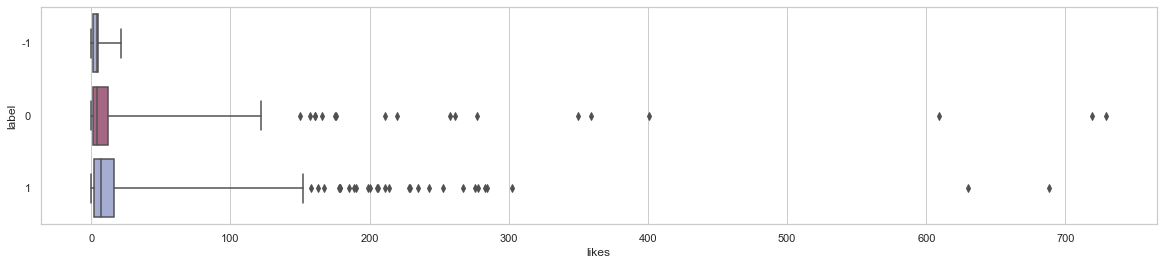

In [8]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme(style="whitegrid", palette="pastel")

plot = df
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='likes', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

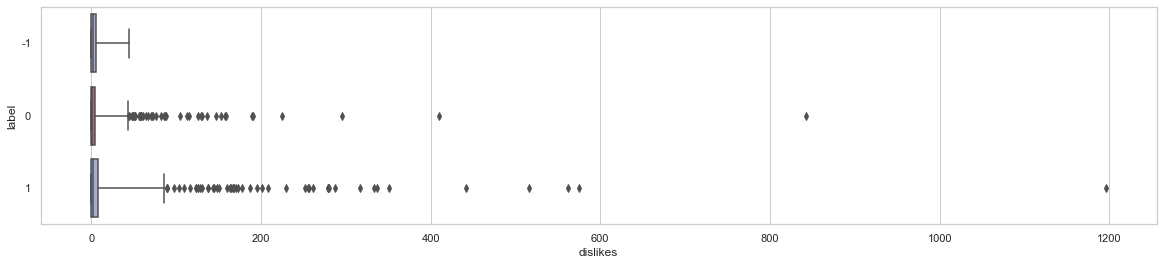

In [9]:
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='dislikes', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

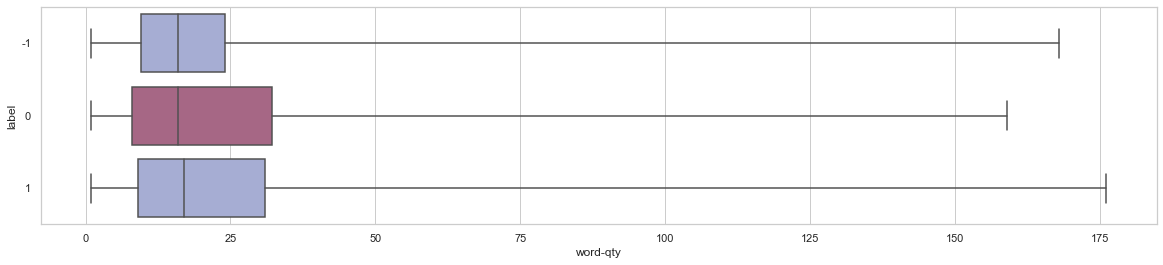

In [10]:
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='word-qty', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

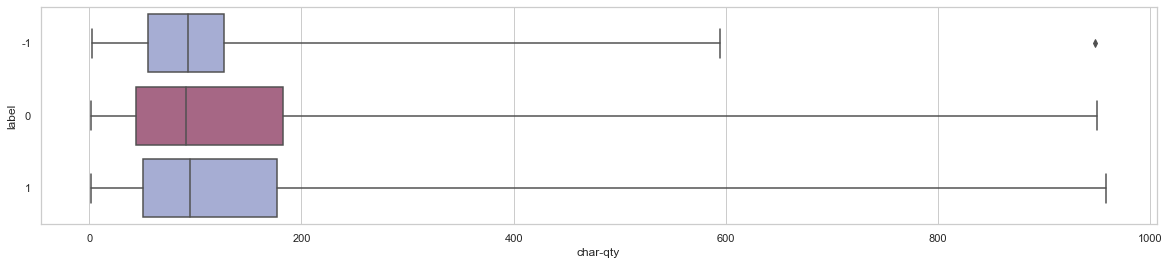

In [11]:
dims = (20, 4)
fig, ax = pyplot.subplots(figsize=dims)
a = sns.boxplot(y='label', x='char-qty', data=plot, palette=["#9FA8DA", "#B05C84"], orient='h',whis=10)

In [12]:
!pip3 install tqdm
!pip3 install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: problems found:
        - require?  X jupyter-js-widgets/extension


# Generate train and test

In [40]:
df = pd.read_csv('data/dataframe.csv', sep=';')
columns = [f'TFus_{i}' for i in range(100)] + \
    [f'TFun_{i}' for i in range(100)] + \
    [f'TFbs_{i}' for i in range(100)] + \
    [f'TFbn_{i}' for i in range(100)] + \
    [f'TFpos_{i}' for i in range(199)] + \
    ['likes','dislikes','char-qty','word-qty', 'legibility-index', 'sexist']

df.columns = columns
df

,TFus_0,TFus_1,TFus_2,TFus_3,TFus_4,TFus_5,TFus_6,TFus_7,TFus_8,TFus_9,...,TFpos_195,TFpos_196,TFpos_197,TFpos_198,likes,dislikes,char-qty,word-qty,legibility-index,sexist
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,2.0,0.0,0.0,686,117,228.58,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,8.0,37,8,230.14,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,18,2,204.50,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,13.0,60.0,182,33,221.43,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,8.0,148,20,230.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,121,19,229.05,1
3529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,217,33,224.14,0
3530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,12,1,163.22,0
3531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,63,13,229.22,1


In [41]:
def generate_cross_validation_train_and_test(df):
    train_size = math.floor(df.shape[0] * 0.9)
    test_size = math.ceil(df.shape[0] * 0.1)
    for i in range (0,10):
        dataframe = df.sample(frac=1)
        train = dataframe.iloc[:train_size]
        test = dataframe.iloc[train_size:]
        train.to_csv(f'./data/{i+1}_train.csv', index=False)
        test.to_csv(f'./data/{i+1}_test.csv', index=False)


# Training and testing models

In [43]:
from sklearn.pipeline import make_pipeline
from joblib import parallel_backend
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# if GENERATE_TRAIN_TEST:
generate_cross_validation_train_and_test(df)

results = []
for i in tqdm(range(0, 10)):
    # ------- loading data
    train = pd.read_csv(f'./data/{i+1}_train.csv')
    test = pd.read_csv(f'./data/{i+1}_test.csv')
    X_train = train.drop(columns=['sexist'])
    y_train = train['sexist']
    X_test = test.drop(columns=['sexist'])
    y_test = test['sexist']
    
    # ------- selection features combination
    feature_combinations = {
        'TFus' : [x for x in list(train.columns) if 'TFus' in x], # sexist unigrams TFs
        'TFun' : [x for x in list(train.columns) if 'TFun' in x], # not-sexist unigrams TFs
        'TFbs' : [x for x in list(train.columns) if 'TFbs' in x], # sexist bigrams TFs
        'TFbn' : [x for x in list(train.columns) if 'TFbn' in x], # not sexist bigrams TFs
        'TFpos' : [x for x in list(train.columns) if 'TFpos' in x], # pos tagging TFs
        'L' : ['likes'], # likes quantity
        'D' : ['dislikes'], # dislikes quantity
        'CQ' : ['char-qty'], # chars quantity
        'WQ' : ['word-qty'], # word quantity
        'LI' : ['legibility-index'] # legibility index
    }
    feature_combinations['CQWQ'] = feature_combinations['CQ'] + feature_combinations['WQ']
    feature_combinations['LD'] = feature_combinations['L'] + feature_combinations['D']
    feature_combinations['Q'] = feature_combinations['LD'] + feature_combinations['CQWQ']
    
    feature_combinations['TFu'] = feature_combinations['TFus'] + feature_combinations['TFun']
    feature_combinations['TFb'] = feature_combinations['TFbs'] + feature_combinations['TFbn']
    feature_combinations['TF'] = feature_combinations['TFu'] + feature_combinations['TFb']
    feature_combinations['TFuQ'] = feature_combinations['TFu'] + feature_combinations['Q']    
    
    combination_results = dict({})

    for combination in tqdm(feature_combinations.keys()):
        X_train_ = select_df_columns(X_train, feature_combinations[combination])
        X_test_ = select_df_columns(X_test, feature_combinations[combination])

        # ------ training SVM
        model_path = f'{MODELS_PATH}/{i}_SVM_{combination}'

        try:
            svm = pickle.load(open(model_path, 'rb'))
        except:
            svm = SVC(kernel='rbf', C=1.0, gamma='scale')
            with parallel_backend('threading', n_jobs=12):
                svm.fit(X_train_ ,y_train)
            pickle.dump(svm, open(model_path, 'wb'))

        # ------ testing SVM
        y = svm.predict(X_test_)
        precision, recall, fscore, _ = score(y_test, y, average=None, labels=[1, 0])
        report = build_results_report(f'{i}_SVM_{combination}', precision, recall, fscore, f1_score(y_test,y))
        combination_results[f'{i}_SVM_{combination}'] = report
        # print_report(report)

        # ------ training KNN
        model_path = f'{MODELS_PATH}/{i}_KNN_{combination}'
        try:
            knn = pickle.load(open(model_path, 'rb'))
        except:
            knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
            with parallel_backend('threading', n_jobs=12):
                knn.fit(X_train_,y_train)
            pickle.dump(knn, open(model_path, 'wb'))

        # ------ testing KNN
        y = knn.predict(X_test_)
        precision, recall, fscore, _ = score(y_test, y, average=None, labels=[1, 0])
        report = build_results_report(f'{i}_KNN_{combination}', precision, recall, fscore, f1_score(y_test,y))
        combination_results[f'{i}_KNN_{combination}'] = report
        # print_report(report)

        # ------ training RFC
        model_path = f'{MODELS_PATH}/{i}_RFC_{combination}'
        print(model_path)
        try:
            rfc = pickle.load(open(model_path, 'rb'))
        except:
            rfc = RandomForestClassifier(n_estimators=200, max_depth=8)
            with parallel_backend('threading', n_jobs=12):
                rfc.fit(X_train_,y_train)
            pickle.dump(rfc, open(model_path, 'wb'))
        # ------ testing RFC
        y = rfc.predict(X_test_)
        precision, recall, fscore, _ = score(y_test, y, average=None, labels=[1, 0])
        report = build_results_report(f'{i}_RFC_{combination}', precision, recall, fscore, f1_score(y_test,y))
        combination_results[f'{i}_RFC_{combination}'] = report
        # print_report(report)

    results.append(combination_results)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/0_RFC_TFus
./data/models/0_RFC_TFun
./data/models/0_RFC_TFbs
./data/models/0_RFC_TFbn
./data/models/0_RFC_TFpos
./data/models/0_RFC_L
./data/models/0_RFC_D
./data/models/0_RFC_CQ
./data/models/0_RFC_WQ
./data/models/0_RFC_LI
./data/models/0_RFC_CQWQ
./data/models/0_RFC_LD
./data/models/0_RFC_Q
./data/models/0_RFC_TFu
./data/models/0_RFC_TFb
./data/models/0_RFC_TF
./data/models/0_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/1_RFC_TFus
./data/models/1_RFC_TFun
./data/models/1_RFC_TFbs
./data/models/1_RFC_TFbn
./data/models/1_RFC_TFpos
./data/models/1_RFC_L
./data/models/1_RFC_D
./data/models/1_RFC_CQ
./data/models/1_RFC_WQ
./data/models/1_RFC_LI
./data/models/1_RFC_CQWQ
./data/models/1_RFC_LD
./data/models/1_RFC_Q
./data/models/1_RFC_TFu
./data/models/1_RFC_TFb
./data/models/1_RFC_TF
./data/models/1_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/2_RFC_TFus
./data/models/2_RFC_TFun
./data/models/2_RFC_TFbs
./data/models/2_RFC_TFbn
./data/models/2_RFC_TFpos
./data/models/2_RFC_L
./data/models/2_RFC_D
./data/models/2_RFC_CQ
./data/models/2_RFC_WQ
./data/models/2_RFC_LI
./data/models/2_RFC_CQWQ
./data/models/2_RFC_LD
./data/models/2_RFC_Q
./data/models/2_RFC_TFu
./data/models/2_RFC_TFb
./data/models/2_RFC_TF
./data/models/2_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/3_RFC_TFus
./data/models/3_RFC_TFun
./data/models/3_RFC_TFbs
./data/models/3_RFC_TFbn
./data/models/3_RFC_TFpos
./data/models/3_RFC_L
./data/models/3_RFC_D
./data/models/3_RFC_CQ
./data/models/3_RFC_WQ
./data/models/3_RFC_LI
./data/models/3_RFC_CQWQ
./data/models/3_RFC_LD
./data/models/3_RFC_Q
./data/models/3_RFC_TFu
./data/models/3_RFC_TFb
./data/models/3_RFC_TF
./data/models/3_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/4_RFC_TFus
./data/models/4_RFC_TFun
./data/models/4_RFC_TFbs
./data/models/4_RFC_TFbn
./data/models/4_RFC_TFpos
./data/models/4_RFC_L
./data/models/4_RFC_D
./data/models/4_RFC_CQ
./data/models/4_RFC_WQ
./data/models/4_RFC_LI
./data/models/4_RFC_CQWQ
./data/models/4_RFC_LD
./data/models/4_RFC_Q
./data/models/4_RFC_TFu
./data/models/4_RFC_TFb
./data/models/4_RFC_TF
./data/models/4_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/5_RFC_TFus
./data/models/5_RFC_TFun
./data/models/5_RFC_TFbs
./data/models/5_RFC_TFbn
./data/models/5_RFC_TFpos
./data/models/5_RFC_L
./data/models/5_RFC_D
./data/models/5_RFC_CQ
./data/models/5_RFC_WQ
./data/models/5_RFC_LI
./data/models/5_RFC_CQWQ
./data/models/5_RFC_LD
./data/models/5_RFC_Q
./data/models/5_RFC_TFu
./data/models/5_RFC_TFb
./data/models/5_RFC_TF
./data/models/5_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/6_RFC_TFus
./data/models/6_RFC_TFun
./data/models/6_RFC_TFbs
./data/models/6_RFC_TFbn
./data/models/6_RFC_TFpos
./data/models/6_RFC_L
./data/models/6_RFC_D
./data/models/6_RFC_CQ
./data/models/6_RFC_WQ
./data/models/6_RFC_LI
./data/models/6_RFC_CQWQ
./data/models/6_RFC_LD
./data/models/6_RFC_Q
./data/models/6_RFC_TFu
./data/models/6_RFC_TFb
./data/models/6_RFC_TF
./data/models/6_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/7_RFC_TFus
./data/models/7_RFC_TFun
./data/models/7_RFC_TFbs
./data/models/7_RFC_TFbn
./data/models/7_RFC_TFpos
./data/models/7_RFC_L
./data/models/7_RFC_D
./data/models/7_RFC_CQ
./data/models/7_RFC_WQ
./data/models/7_RFC_LI
./data/models/7_RFC_CQWQ
./data/models/7_RFC_LD
./data/models/7_RFC_Q
./data/models/7_RFC_TFu
./data/models/7_RFC_TFb
./data/models/7_RFC_TF
./data/models/7_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/8_RFC_TFus
./data/models/8_RFC_TFun
./data/models/8_RFC_TFbs
./data/models/8_RFC_TFbn
./data/models/8_RFC_TFpos
./data/models/8_RFC_L
./data/models/8_RFC_D
./data/models/8_RFC_CQ
./data/models/8_RFC_WQ
./data/models/8_RFC_LI
./data/models/8_RFC_CQWQ
./data/models/8_RFC_LD
./data/models/8_RFC_Q
./data/models/8_RFC_TFu
./data/models/8_RFC_TFb
./data/models/8_RFC_TF
./data/models/8_RFC_TFuQ


  0%|          | 0/17 [00:00<?, ?it/s]

./data/models/9_RFC_TFus
./data/models/9_RFC_TFun
./data/models/9_RFC_TFbs
./data/models/9_RFC_TFbn
./data/models/9_RFC_TFpos
./data/models/9_RFC_L
./data/models/9_RFC_D
./data/models/9_RFC_CQ
./data/models/9_RFC_WQ
./data/models/9_RFC_LI
./data/models/9_RFC_CQWQ
./data/models/9_RFC_LD
./data/models/9_RFC_Q
./data/models/9_RFC_TFu
./data/models/9_RFC_TFb
./data/models/9_RFC_TF
./data/models/9_RFC_TFuQ


# Computing results

In [44]:
import re
final_results = dict({})
mean_results = dict({})

for result in results:
    for key in result.keys():
        final_key = re.sub('\d+_', '', key)
        if final_key not in final_results.keys():    
            final_results[final_key] = {
                'precision': {'1': [], '0': []},
                'recall': {'1': [], '0': []},
                'f1': {'1': [], '0': []},
                'f1_macro': []
            }

        current = result[key]
        final_results[final_key]['precision']['1'].append(current['precision']['1'][0])
        final_results[final_key]['precision']['0'].append(current['precision']['0'][0])
        final_results[final_key]['recall']['1'].append(current['recall']['1'][0])
        final_results[final_key]['recall']['0'].append(current['recall']['0'][0])
        final_results[final_key]['f1']['1'].append(current['f1']['1'][0])
        final_results[final_key]['f1']['0'].append(current['f1']['0'][0])
        final_results[final_key]['f1_macro'].append(current['f1_macro'][0])

In [45]:
def med(array):
    return sum(array)/10

for key in final_results.keys():
    mean_results[key] = {
        'title': key,
        'precision': {'1': med(final_results[key]['precision']['1']),
                      '0': med(final_results[key]['precision']['0'])},
        'recall': {'1': med(final_results[key]['recall']['1']),
                      '0': med(final_results[key]['recall']['0'])},
        'f1': {'1': med(final_results[key]['f1']['1']),
                      '0': med(final_results[key]['f1']['0'])},
    }

In [46]:
pickle.dump(mean_results, open('./data/results','wb'))

In [47]:
for key in mean_results.keys():
    if 'SVM' in key:
        print_report(mean_results[key])
        
for key in mean_results.keys():
    if 'KNN' in key:
        print_report(mean_results[key])
        
for key in mean_results.keys():
    if 'RFC' in key:
        print_report(mean_results[key])

>>>> SVM_TFus results
		 sexist 	 not-sexist
precision	 0.98057 	 0.81251
recall		 0.79007 	 0.98289
f1		 0.87497 	 0.88949

>>>> SVM_TFun results
		 sexist 	 not-sexist
precision	 0.97806 	 0.78578
recall		 0.75192 	 0.98199
f1		 0.85003 	 0.87280

>>>> SVM_TFbs results
		 sexist 	 not-sexist
precision	 0.64159 	 0.53942
recall		 0.39707 	 0.76038
f1		 0.48907 	 0.63042

>>>> SVM_TFbn results
		 sexist 	 not-sexist
precision	 0.57187 	 0.60418
recall		 0.76676 	 0.38153
f1		 0.65480 	 0.46667

>>>> SVM_TFpos results
		 sexist 	 not-sexist
precision	 0.99225 	 0.98137
recall		 0.98264 	 0.99188
f1		 0.98739 	 0.98656

>>>> SVM_L results
		 sexist 	 not-sexist
precision	 0.61201 	 0.54775
recall		 0.49457 	 0.66081
f1		 0.54685 	 0.59883

>>>> SVM_D results
		 sexist 	 not-sexist
precision	 0.65894 	 0.52497
recall		 0.30453 	 0.82848
f1		 0.41574 	 0.64242

>>>> SVM_CQ results
		 sexist 	 not-sexist
precision	 0.55307 	 0.53642
recall		 0.65168 	 0.43305
f1		 0.59794 	 0.47862

>>>> SV

# Wilcoxon

In [ ]:
final_results['BERT']= {'f1_macro': [
    0.571069182389937,
    0.45852187028657615,
    0.5364583333333334,
    0.5258964143426295,
    0.5313351498637601,
    0.4828571428571429,
    0.43333333333333335,
    0.5463659147869674,
    0.5493333333333332,
    0.5195822454308094
]}

final_results['B_SVM'] = {'f1_macro': [0.58, 0.6, 0.6, 0.6, 0.59, 0.59, 0.6, 0.6, 0.59, 0.6]}
final_results['B_LR']= {'f1_macro': [0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]}

tests = dict({})
from scipy.stats import wilcoxon
for key_1 in final_results.keys():
    for key_2 in final_results.keys():
        if (key_1 != key_2) and \
            f'{key_1} x {key_2}' not in tests.keys() and\
            f'{key_2} x {key_1}' not in tests.keys():
            values_y = final_results[key_1]['f1_macro']
            values_x = final_results[key_2]['f1_macro']
            test_stat, test_p = wilcoxon(values_y, values_x)
            tests[f'{key_1} x {key_2}'] = test_p

In [ ]:
pickle.dump(tests, open('./data/wilcoxon', 'wb'))